
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases.
Several constraints were placed on the selection of these instances from a larger database. 
In particular, all patients here are females at least 21 years old of Pima Indian heritage.

Data Columns:
    
    Pregnancies ---> Number of times pregnant.
    Glucose --> Plasma glucose concentration after 2 hours in an oral glucose tolerance test (mg/dl).
    BloodPressure ---> Diastolic blood pressure (mm Hg).
    SkinThickness ---> Triceps skin fold thickness (mm).
    Insulin ---> 2-Hour serum insulin ( muU/ml)
    BMI ---> Body mass index (weight in kg/(height in m)^2)
    DiabetesPedigreeFunction ---> Diabetes pedigree function.
    Age ---> Age (years)
    Outcome ---> 0 : not end with dbt diagnosis or 1 : end with dbt diagnosis.


## Importing libraries for analysis

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss


from collections import Counter

# INITIAL EXPLORATION

In [2]:
df = pd.read_csv('diabetes.csv')

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Checking number of rows and columns

In [4]:
df.shape

(768, 9)

### Checking for column dataypes and Na count

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Summary statistics of numerical columns

In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Initial exploration of numerical columns

In [7]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

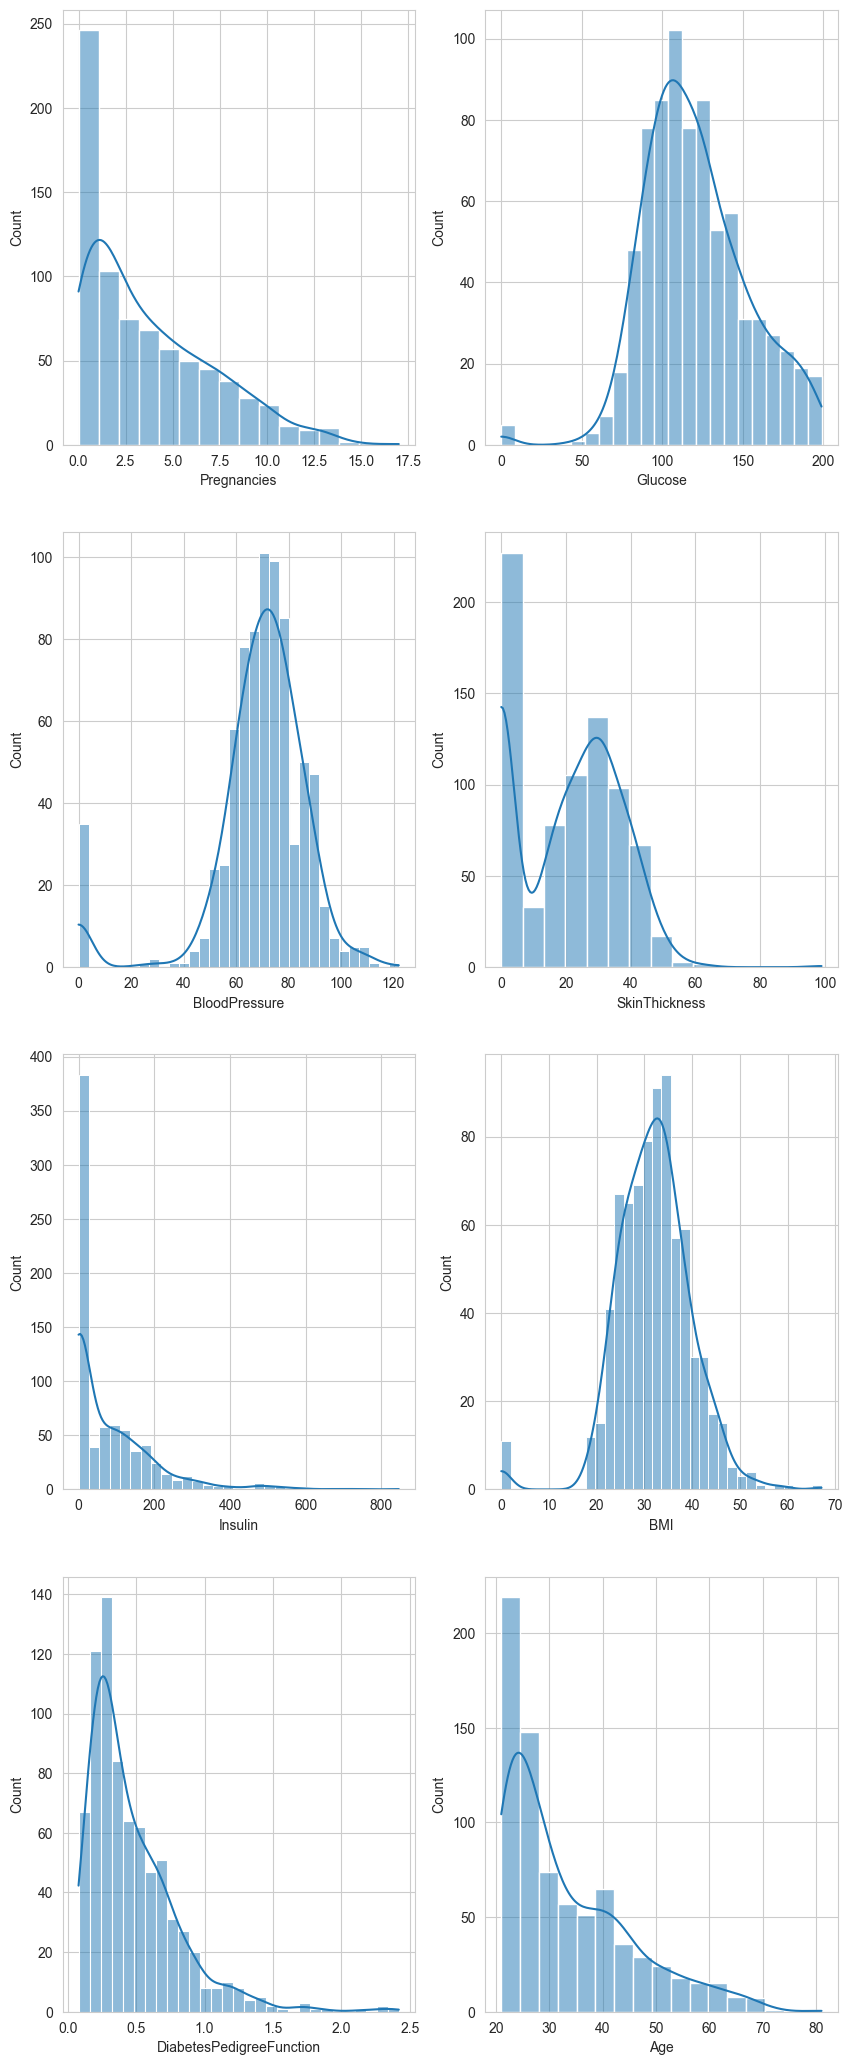

In [8]:
sns.set_style('whitegrid')

fig, axs = plt.subplots(4, 2, figsize=(10,26))

sns.histplot(x='Pregnancies', data=df, ax=axs[0, 0], kde=True)

sns.histplot(x='Glucose', data=df, ax=axs[0, 1], kde=True)

sns.histplot(x='BloodPressure', data=df, ax=axs[1, 0], kde=True)

sns.histplot(x='SkinThickness', data=df, ax=axs[1, 1], kde=True)

sns.histplot(x='Insulin', data=df, ax=axs[2, 0], kde=True)

sns.histplot(x='BMI', data=df, ax=axs[2, 1], kde=True)

sns.histplot(x='DiabetesPedigreeFunction', data=df, ax=axs[3, 0], kde=True)

sns.histplot(x='Age', data=df, ax=axs[3, 1], kde=True)


plt.show()

***'Glucose' , 'BloodPressure', 'BMI' follow a normal distribution***

***'SkinThickness', 'Insulin', 'Age', 'DiabetesPedigreeFunction', 'Pregnancies' distributions are skewed***

***'Glucose' , 'BloodPressure', 'SkinThickness', 'Insulin' and 'BMI' variable have '0' values, that is not biologically possible so it must correspond to Nan values***

# DATA PROCESSING

### Cheking for Na values

In [9]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Checking for 0 values

In [10]:
for column in df[['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']]:
    n_of_0 = df[df[column] == 0].shape
    print(f'{column} : {n_of_0[0]}')

Glucose : 5
BloodPressure : 35
SkinThickness : 227
BMI : 11
Insulin : 374


### Replacing '0' values of 'Glucose' , 'BloodPressure ', 'SkinThickness', 'Insulin' and 'BMI' to Na values.

In [11]:
df['Glucose'] = df['Glucose'].replace(0, np.nan)
df['BloodPressure'] = df['BloodPressure'].replace(0, np.nan)
df['SkinThickness'] = df['SkinThickness'].replace(0, np.nan)
df['Insulin'] = df['Insulin'].replace(0, np.nan)
df['BMI'] = df['BMI'].replace(0, np.nan)

### Rechecking for Na values

In [12]:
(df.isna().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [13]:
(df.isna().sum()) / len(df)

Pregnancies                 0.000000
Glucose                     0.006510
BloodPressure               0.045573
SkinThickness               0.295573
Insulin                     0.486979
BMI                         0.014323
DiabetesPedigreeFunction    0.000000
Age                         0.000000
Outcome                     0.000000
dtype: float64

### Handling of Nan values

#### 'Glucose', 'BloodPressure' and 'BMI' are normally distributed, proceed to impute the Nan values with the mean of the column.

In [14]:
mean_imputer = SimpleImputer(strategy='mean')

df[['Glucose', 'BloodPressure', 'BMI']] = mean_imputer.fit_transform(df[['Glucose', 'BloodPressure', 'BMI']])

mean_imputer.statistics_

array([121.68676278,  72.40518417,  32.45746367])

In [15]:
df.isna().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                 0
SkinThickness               227
Insulin                     374
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

#### Imputing 'Insulin' and 'Skin Thickness' Na values, based on 'Age', 'Glucose', 'BMI' using knn algorithm

In [16]:
selected_data = df[['Age', 'Glucose', 'BMI', 'Insulin']]

knn_imputer = KNNImputer(n_neighbors=5)
imputed_insulin = knn_imputer.fit_transform(selected_data)
imputed_insulin = pd.DataFrame(imputed_insulin, columns=['Age', 'Glucose', 'BMI', 'Insulin'])

df['Insulin'] = imputed_insulin['Insulin']

In [17]:
selected_data = df[['Age', 'Glucose', 'BMI', 'SkinThickness']]

imputed_skin_thickness = knn_imputer.fit_transform(selected_data)
imputed_skin_thickness = pd.DataFrame(imputed_skin_thickness, columns=['Age', 'Glucose', 'BMI', 'SkinThickness'])

df['SkinThickness'] = imputed_skin_thickness['SkinThickness']

### Recheking for Na values

In [18]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Rechecking distributions after handling of Na values

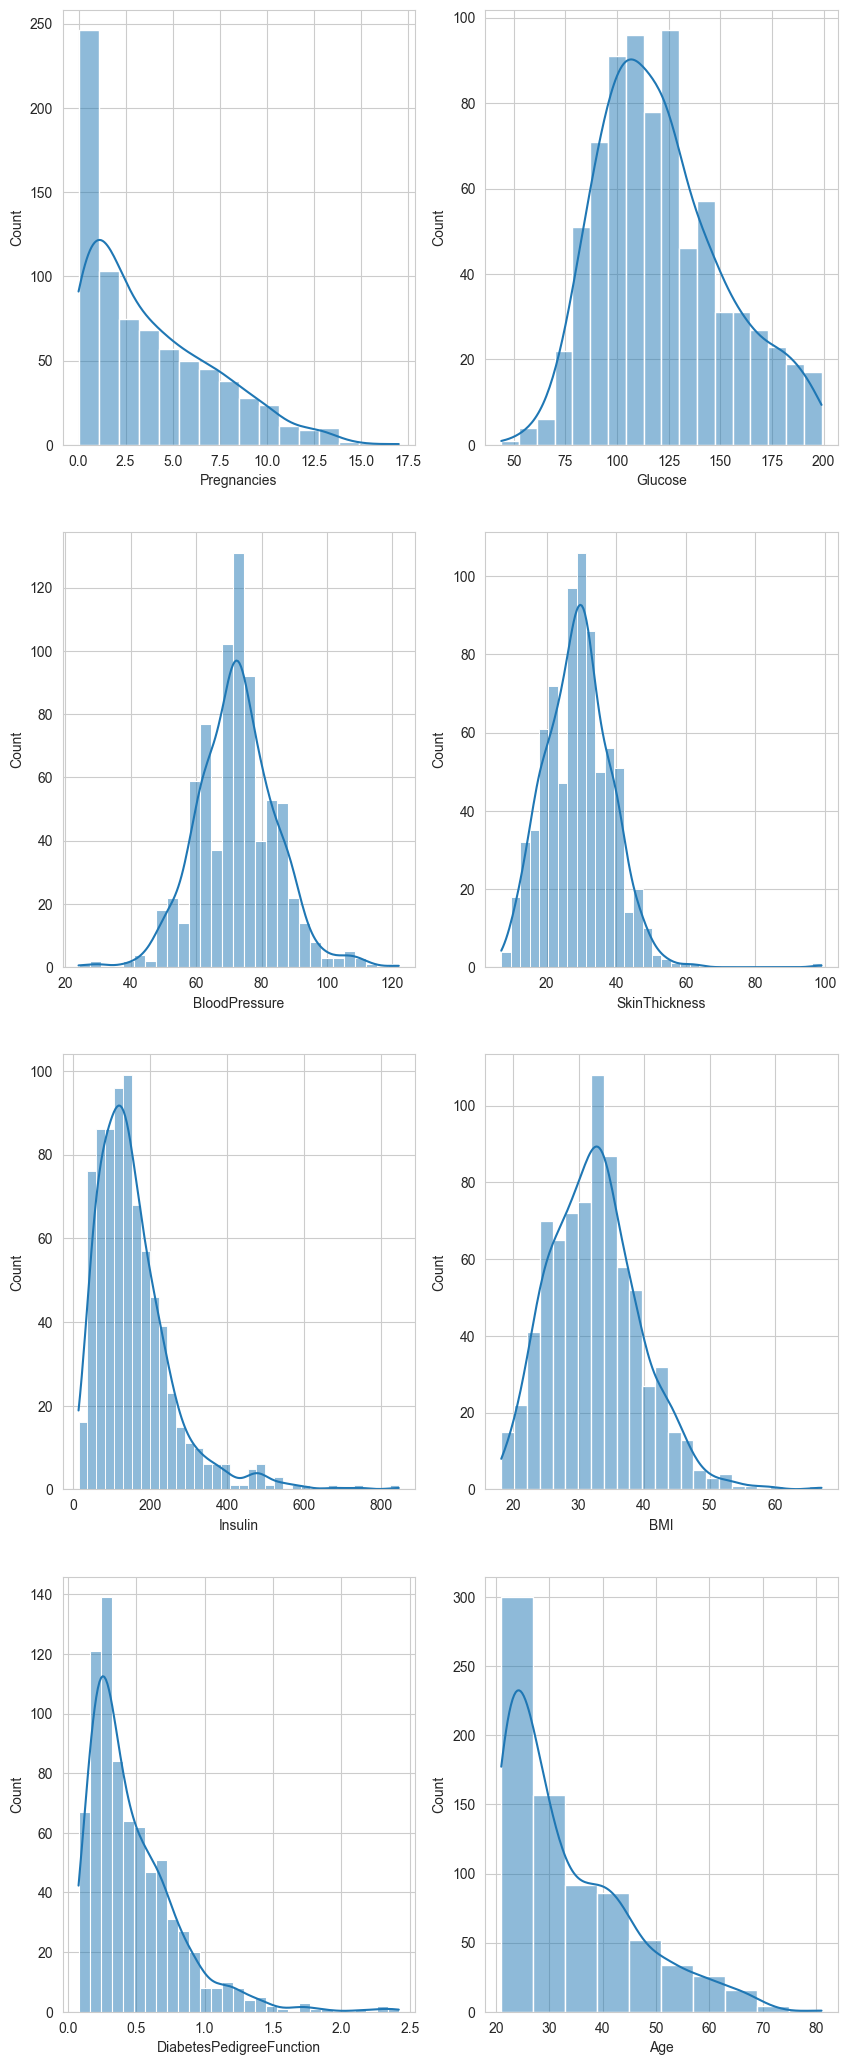

In [19]:
sns.set_style('whitegrid')

faig, axs = plt.subplots(4, 2, figsize=(10,26))

sns.histplot(x='Pregnancies', data=df, ax=axs[0, 0], kde=True)

sns.histplot(x='Glucose', data=df, ax=axs[0, 1], kde=True)

sns.histplot(x='BloodPressure', data=df, ax=axs[1, 0], kde=True)

sns.histplot(x='SkinThickness', data=df, ax=axs[1, 1], kde=True)

sns.histplot(x='Insulin', data=df, ax=axs[2, 0], kde=True)

sns.histplot(x='BMI', data=df, ax=axs[2, 1], kde=True)

sns.histplot(x='DiabetesPedigreeFunction', data=df, ax=axs[3, 0], kde=True)

sns.histplot(x='Age', data=df, ax=axs[3, 1], kde=True, bins=10)


plt.show()

### Checking for outliers

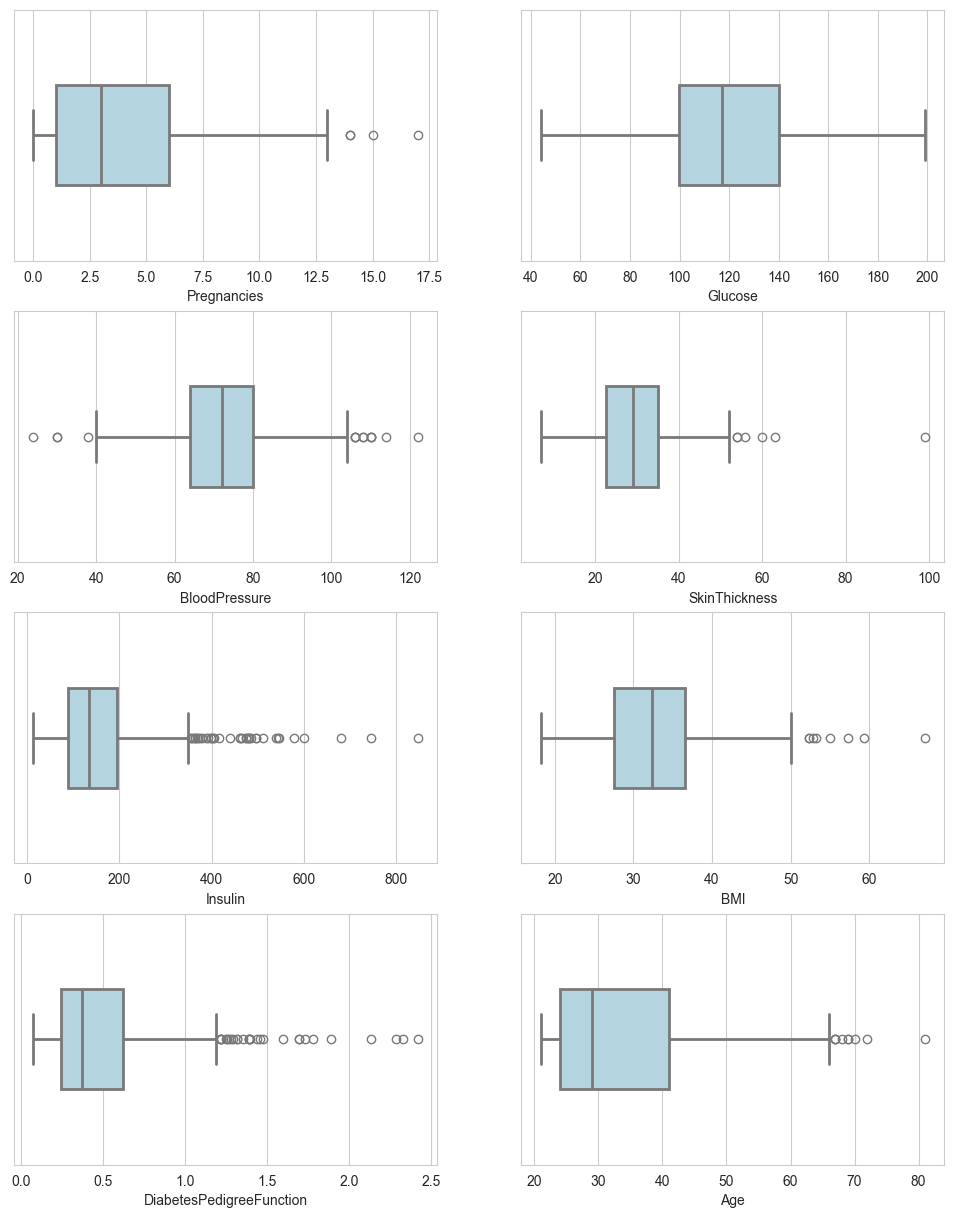

In [20]:
sns.set_style('whitegrid')

fig, axs = plt.subplots(4, 2, figsize=(12, 15))

sns.boxplot(x=df['Pregnancies'], data=df, ax=axs[0, 0],  width = 0.4, linewidth = 2, color='lightblue')

sns.boxplot(x=df['Glucose'],data=df, ax=axs[0, 1],  width = 0.4, linewidth = 2, color='lightblue')

sns.boxplot(x=df['BloodPressure'], data=df, ax=axs[1, 0],  width = 0.4, linewidth = 2, color='lightblue')

sns.boxplot(x=df['SkinThickness'], data=df, ax=axs[1, 1],  width = 0.4, linewidth = 2, color='lightblue')

sns.boxplot(x=df['Insulin'], data=df, ax=axs[2, 0],  width = 0.4, linewidth = 2, color='lightblue')

sns.boxplot(x=df['BMI'], data=df, ax=axs[2, 1],  width = 0.4, linewidth = 2, color='lightblue')

sns.boxplot(x=df['DiabetesPedigreeFunction'], data=df, ax=axs[3, 0],  width = 0.4, linewidth = 2, color='lightblue')

sns.boxplot(x=df['Age'], data=df, ax=axs[3, 1],  width = 0.4, linewidth = 2, color='lightblue')

plt.show()

In [21]:
num_col = df.select_dtypes(exclude='category').columns
for col in num_col:
    
    q3, q1 = np.percentile(df[col],[75, 25])
    iqr = q3 - q1

    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr

    outliers = df.loc[(df[col] > upper_bound) | (df[col] < lower_bound), col]
    print(f'{col} n ° of outliers : {len(outliers)}')
    print('\t')
    print(outliers)
    print('\t')

Pregnancies n ° of outliers : 4
	
88     15
159    17
298    14
455    14
Name: Pregnancies, dtype: int64
	
Glucose n ° of outliers : 0
	
Series([], Name: Glucose, dtype: float64)
	
BloodPressure n ° of outliers : 14
	
18      30.0
43     110.0
84     108.0
106    122.0
125     30.0
177    110.0
362    108.0
549    110.0
597     24.0
599     38.0
658    106.0
662    106.0
672    106.0
691    114.0
Name: BloodPressure, dtype: float64
	
SkinThickness n ° of outliers : 6
	
57     60.0
86     54.0
120    56.0
211    54.0
445    63.0
579    99.0
Name: SkinThickness, dtype: float64
	
Insulin n ° of outliers : 37
	
8      543.0
13     846.0
100    368.8
111    495.0
153    485.0
186    495.0
212    397.8
220    478.0
228    744.0
231    370.0
235    378.6
245    398.6
247    680.0
248    402.0
258    375.0
286    545.0
296    360.0
319    461.8
370    465.0
392    415.0
399    355.4
408    363.2
409    579.0
415    474.0
486    480.0
489    461.8
579    404.2
584    600.0
645    440.0
655    

***Although there are outliers by definition in all the features, I consider them normal different measurements due to biological variability of individuals, and they are important to be included in the dataset for analysis***

### Creating binary categories for 'Age',  'Glucose' , 'BloodPressure' and 'BMI' features for posterior analysis.

#### Classifying 'Age' into 'Older_45' , using age of 45 as a cutpoint as from the risk of getting type II dbt increases.

In [22]:
df['Age'].describe()

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
25%       24.000000
50%       29.000000
75%       41.000000
max       81.000000
Name: Age, dtype: float64

In [23]:
labels=['No', 'Yes']
bins = [20, 45, 81]

df['Older_45'] = pd.cut(df['Age'], bins=bins, labels=labels)

#### Classifying 'Glucose' into 'AlteredOGTT'(oral glucose tolerance test), refering to glycemia after 2 hours of a glucose load , using as cut points those defined by ADA (American Diabetes Asssociation) for diabetes II diagnosis.

In [24]:
df['Glucose'].describe()

count    768.000000
mean     121.686763
std       30.435949
min       44.000000
25%       99.750000
50%      117.000000
75%      140.250000
max      199.000000
Name: Glucose, dtype: float64

In [25]:
labels=['No', 'Yes']
bins = [44, 139, 199]

df['AlteredOGTT'] = pd.cut(df['Glucose'], bins=bins, labels=labels)

#### Classifying 'BloodPressure' into HighDBP,  if diastolic blood pressure is normal or high(hypertension) according to threshold proposed by ESH (European Society of Hypertension) and taking into consideration that for the diagnosis of hyptertension two measures spaced in time must be made.

In [26]:
df['BloodPressure'].describe()

count    768.000000
mean      72.405184
std       12.096346
min       24.000000
25%       64.000000
50%       72.202592
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64

In [27]:
labels=['No', 'Yes']
bins = [24, 89, 122]

df['HighDBP'] = pd.cut(df['BloodPressure'], bins=bins, labels=labels)

#### Classifying 'BMI' column into 'Obesity' using as threshold the classification defined by WHO.

In [28]:
df['BMI'].describe()

count    768.000000
mean      32.457464
std        6.875151
min       18.200000
25%       27.500000
50%       32.400000
75%       36.600000
max       67.100000
Name: BMI, dtype: float64

In [29]:
labels=['No', 'Yes']
bins = [18.20, 29.9, 67.10]

df['Obesity'] = pd.cut(df['BMI'], bins=bins, labels=labels)

###  Checking for duplicates

In [30]:
df.duplicated().sum()

0

## Reordering variables in df

In [31]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'Older_45',
       'AlteredOGTT', 'HighDBP', 'Obesity'],
      dtype='object')

In [32]:
df = df[['Age', 'Older_45', 'Pregnancies', 'BMI', 'Obesity', 'Glucose', 'AlteredOGTT', 'BloodPressure', 'HighDBP', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Outcome']]

In [33]:
df.head()

,Age,Older_45,Pregnancies,BMI,Obesity,Glucose,AlteredOGTT,BloodPressure,HighDBP,SkinThickness,Insulin,DiabetesPedigreeFunction,Outcome
0,50,Yes,6,33.6,Yes,148.0,Yes,72.0,No,35.0,164.8,0.627,1
1,31,No,1,26.6,No,85.0,No,66.0,No,29.0,66.8,0.351,0
2,32,No,8,23.3,No,183.0,Yes,64.0,No,30.8,229.0,0.672,1
3,21,No,1,28.1,No,89.0,No,66.0,No,23.0,94.0,0.167,0
4,33,No,0,43.1,Yes,137.0,No,40.0,No,35.0,168.0,2.288,1


## Casting 'Outcome' to a binary categorical variable 

In [34]:
df['Outcome'] = df['Outcome'].astype('category')

## FEATURE EXPLORATION

### Exploring the relationship between 'Glucose' and 'Age'

In [35]:
df.groupby('Older_45', observed=True)['Glucose'].mean()

Older_45
No     119.282206
Yes    134.932203
Name: Glucose, dtype: float64

<Axes: xlabel='Glucose', ylabel='Density'>

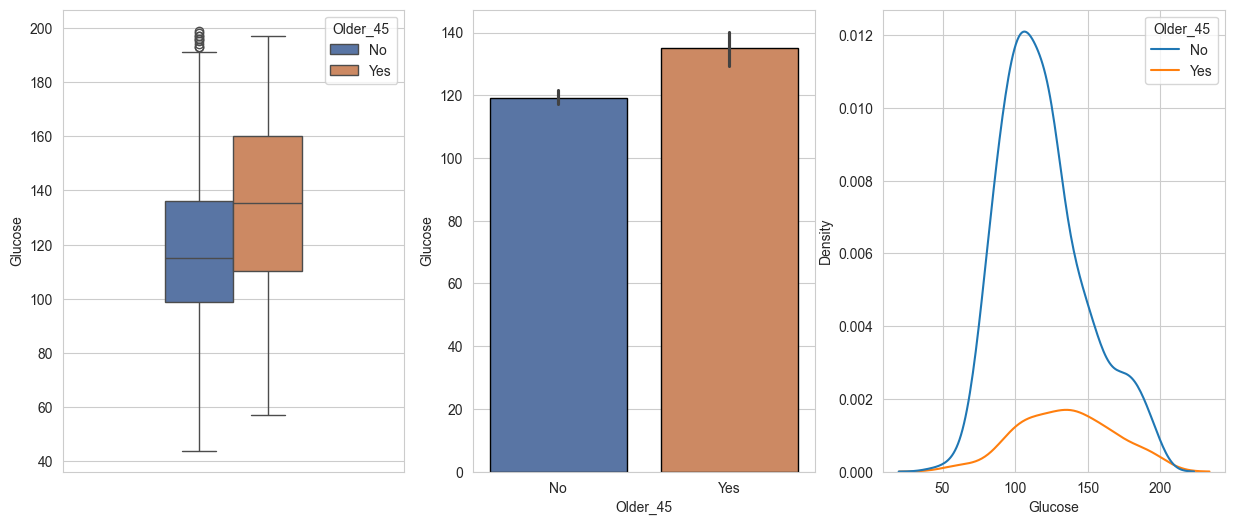

In [36]:
sns.set_style('whitegrid')

fig, axs = plt.subplots(1, 3, figsize=(15, 6))

sns.boxplot(y='Glucose', hue='Older_45', data=df, width=0.4, ax=axs[0], palette='deep' )
sns.barplot(x='Older_45',y='Glucose', hue='Older_45', data=df, ax=axs[1], palette='deep',edgecolor='black')
sns.kdeplot(x='Glucose', hue= 'Older_45', data=df, ax=axs[2])

H0 :There is no difference in the glycemia between patients older and younger 45 years.
    
    (X̄older_45 = X̄younger_45)

H1 :Glycemia in  patients older 45 is higher.
    
    (X̄older_45 > X̄younger_45)

#### Performing unpaired t test between the two means

In [72]:
older_45 = np.array(df[df['Older_45'] == 'Yes']['Glucose'])
younger_45 = np.array(df[df['Older_45'] == 'No']['Glucose'])

t, p = ttest_ind(a=older_45, b=younger_45, equal_var=True)

print(f't value : {t}, p value : {p / 2}')

t value : 5.225989666559967, p value : 1.1177807151036757e-07


***Patients older than 45 years have a higher glycemia after 2 hours a glucose load test (p < 0.05).***

### Exploring relationship between 'Glucose' and 'Obesity'

In [38]:
df.groupby('Obesity', observed=True)['Glucose'].mean()

Obesity
No     114.139622
Yes    126.275487
Name: Glucose, dtype: float64

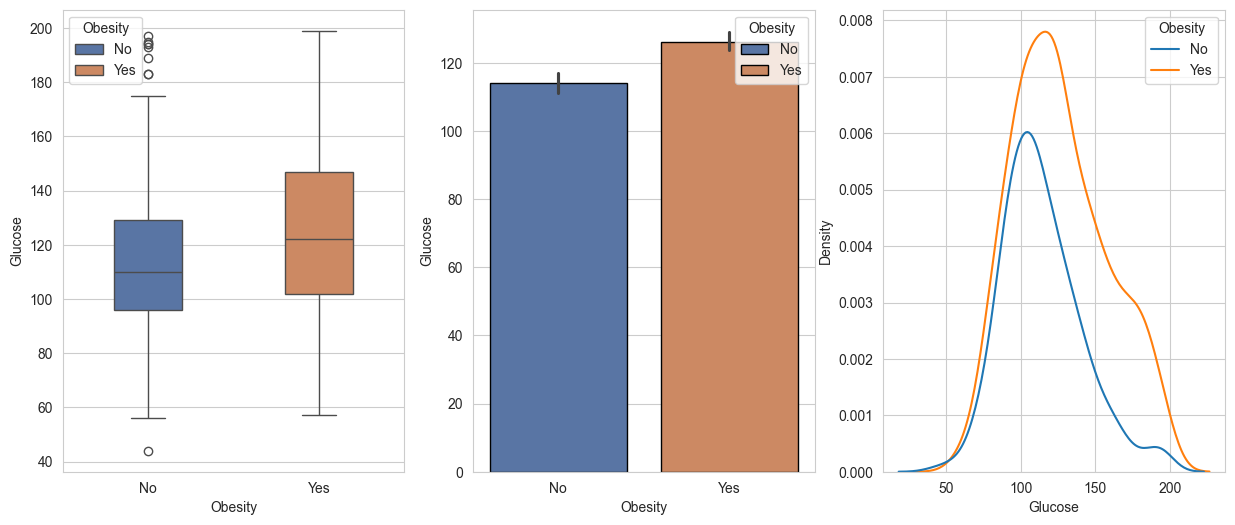

In [39]:
sns.set_style('whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

sns.boxplot(y='Glucose', x='Obesity', hue='Obesity', data=df, width=0.4, ax=axs[0], palette='deep')
sns.barplot(y='Glucose', x='Obesity', hue='Obesity', data=df, ax = axs[1], palette='deep', edgecolor='black')
sns.kdeplot(x='Glucose', hue= 'Obesity', data=df, ax=axs[2])

plt.show()

H0 :There is no difference in the glycemia between obese and not obese patients.
    
    (X̄obese = X̄not_obese)

H1 :Glycemia in obese patients is higher.
    
    (X̄obese > X̄not_obese)

#### Performing unpaired t test between the two means

In [40]:
g_obese = np.array(df[df['Obesity'] == 'Yes']['Glucose'])
g_not_obese = np.array(df[df['Obesity'] == 'No']['Glucose'])

In [73]:
t, p = ttest_ind(a=g_obese, b=g_not_obese, equal_var=True)

print(f't value : {t}, p value : {p / 2}')

t value : 5.418117310726004, p value : 4.040546926204466e-08


***Glycemia after 2 post glucose load is higher in patients with obesity (p <0.05)***

### Exploring relationship between 'Glucose' and 'BloodPressure'

In [42]:
g_b = df.groupby('HighDBP', observed=True)['Glucose'].mean()
g_b

HighDBP
No     120.55224
Yes    135.60000
Name: Glucose, dtype: float64

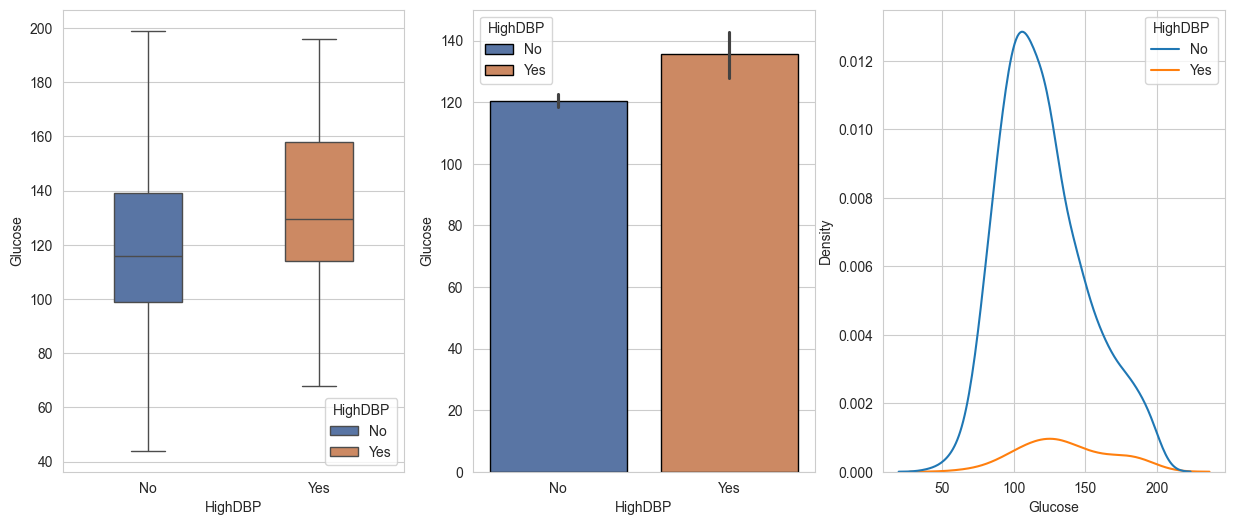

In [43]:
sns.set_style('whitegrid')

fig, axs = plt.subplots(1, 3, figsize=(15, 6))

sns.boxplot(y='Glucose', x='HighDBP', hue='HighDBP', data=df, width=0.4, ax=axs[0], palette='deep')
sns.barplot(y='Glucose', x='HighDBP', hue='HighDBP', data=df, ax = axs[1], palette='deep', edgecolor='black')
sns.kdeplot(x='Glucose', hue= 'HighDBP', data=df, ax=axs[2])
plt.show()

H0 :There is no difference in the glycemia between patients with high and normal diastolic blood pressure(DBP).
    
    X̄high_hdbp = X̄not_hdbp
H1 :Glycemia in patients with high diastolic blood pressure is higher.
    
    X̄high_hdbp > X̄not_hdbp

#### Performing unpaired t test between the two means

In [44]:
g_high_dbp = np.array(df[df['HighDBP'] == 'Yes']['Glucose'])
g_not_high_dbp = np.array(df[df['HighDBP'] == 'No']['Glucose'])

In [74]:
t, p = ttest_ind(a=g_high_dbp, b=g_not_high_dbp, equal_var=True)

print(f't value : {t}, p value : {p / 2}')

t value : 3.7076634709818213, p value : 0.00011214331403812615


***Glycemia after 2 post glucose load is higher in patients with high diastolic blood pressure (p <0.05)***

### Exploring the associaton between the 'Outcome' and 'OGTT', 'HighDBP', 'Age' and 'Obesity'

<Axes: xlabel='Outcome', ylabel='count'>

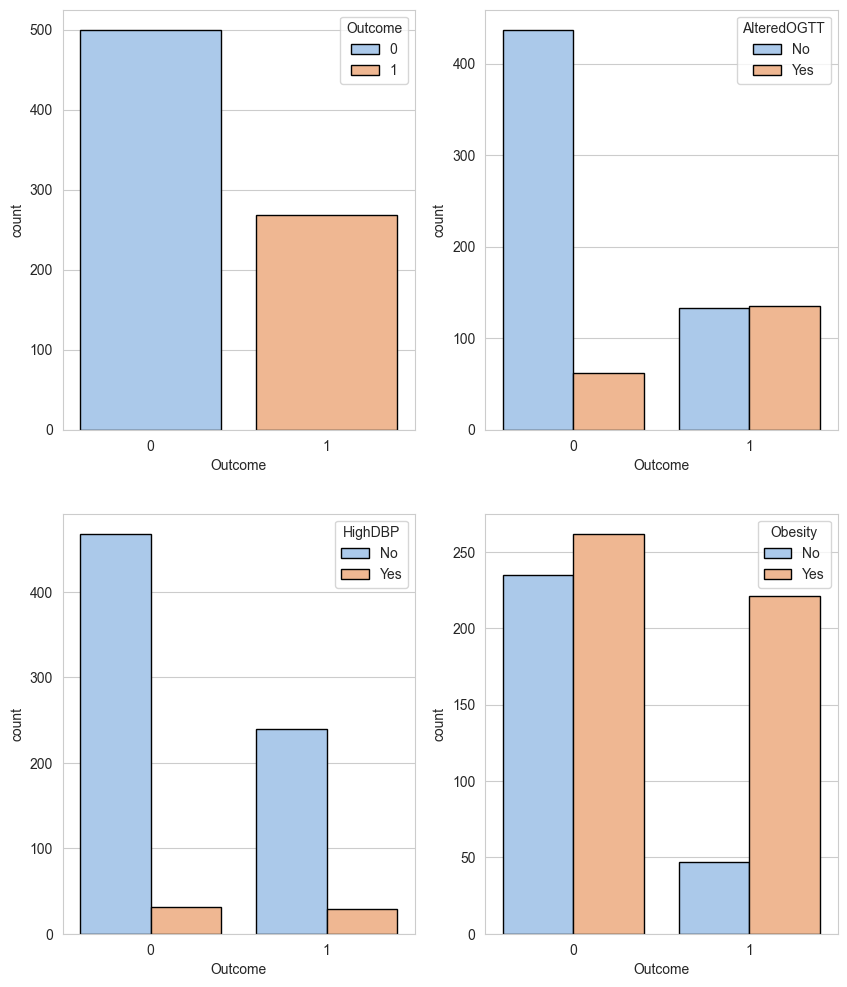

In [46]:
sns.set_style('whitegrid')

fig, axs = plt.subplots(2, 2, figsize=(10, 12))

sns.countplot( x='Outcome', data=df, hue='Outcome', ax=axs[0, 0], palette='pastel', edgecolor='black')
sns.countplot( x='Outcome', data=df, hue='AlteredOGTT', ax=axs[0, 1], palette='pastel', edgecolor='black')
sns.countplot( x='Outcome', data=df, hue='HighDBP', ax=axs[1, 0], palette='pastel', edgecolor='black')
sns.countplot( x='Outcome', data=df, hue='Obesity', ax=axs[1, 1], palette='pastel', edgecolor='black')

### 'Outcome' and 'OGTT'

In [47]:
df.groupby('Outcome', observed=True)['AlteredOGTT'].value_counts()

Outcome  AlteredOGTT
0        No             437
         Yes             62
1        Yes            135
         No             133
Name: count, dtype: int64

H0 : There is no significant association between Altered0GTT and Outcome.

H1 : There is a significant association between Altered0GTT and the diagnosis of DBT.

### Performing chi squared test of independence 

In [76]:
data = [[437, 133], [62, 135]]

stat, p, dof, expected = chi2_contingency(data)

print('stat value:')
print('\t')
print(stat)
print('\t')
print('p value:')
print('\t')
print(p)

stat value:
	
129.56426686303533
	
p value:
	
5.103695383243716e-30


***Patients with an altered OGTT are more diagnosed with DBT (p <0.05)***

### 'Outcome' and 'HighDBP' 

In [49]:
df.groupby('Outcome', observed=True)['HighDBP'].value_counts()

Outcome  HighDBP
0        No         468
         Yes         31
1        No         239
         Yes         29
Name: count, dtype: int64

H0 : There is no significant association between HighDBP and Outcome.

H1 : There is a significant association between HighDBP and the diagnosis of DBT.

In [77]:
data = [[468, 239], [31, 29]]

stat, p, dof, expected = chi2_contingency(data)

print('stat value:')
print('\t')
print(stat)
print('\t')
print('p value:')
print('\t')
print(p)

stat value:
	
4.516165993902772
	
p value:
	
0.03357599309906715


***Patients with a higher diastolic blood pressure are more diagnosed with DBT (p <0.05)***

### 'Outcome' and 'Obesity' 

In [51]:
df.groupby('Outcome', observed=True)['Obesity'].value_counts()

Outcome  Obesity
0        Yes        262
         No         235
1        Yes        221
         No          47
Name: count, dtype: int64

H0 : There is no significant association between Obesity and Outcome.

H1 : There is a significant association between Obesity and the diagnosis of DBT.

In [81]:
data = [[235, 47], [262, 221]]

stat, p, dof, expected = chi2_contingency(data)

print('stat value:')
print('\t')
print(stat)
print('\t')
print('p value:')
print('\t')
print(p)

stat value:
	
64.92303399542463
	
p value:
	
7.788135282836015e-16


***Patients with obesity are more diagnosed with DBT (p <0.05)***

### 'Outcome' and 'Age'

In [53]:
df.groupby('Outcome', observed=True)['Older_45'].value_counts()

Outcome  Older_45
0        No          440
         Yes          60
1        No          210
         Yes          58
Name: count, dtype: int64

H0 : There is no significant association between Age and Outcome.

H1 : There is a significat association between Age and the diagnosis of DBT.

In [79]:
data = [[440, 210], [60, 58]]

stat, p, dof, expected = chi2_contingency(data)

print('stat value:')
print('\t')
print(stat)
print('\t')
print('p value:')
print('\t')
print(p)

stat value:
	
11.742999020023738
	
p value:
	
0.0006107253337278465


***Patients older than 45 years are more diagnosed with DBT (P <0.05)***

In [55]:
numeric_cols = df.select_dtypes(exclude='category')

<Axes: >

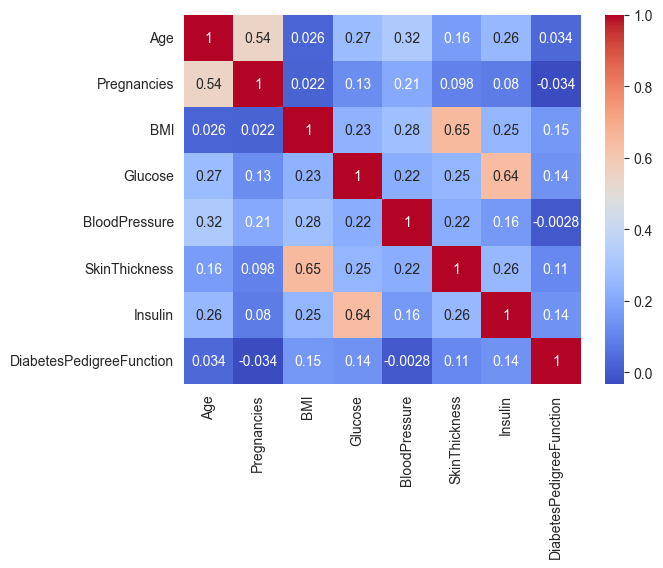

In [56]:
sns.heatmap(numeric_cols.corr(), cmap='coolwarm', annot=True)

<Axes: xlabel='DiabetesPedigreeFunction', ylabel='Glucose'>

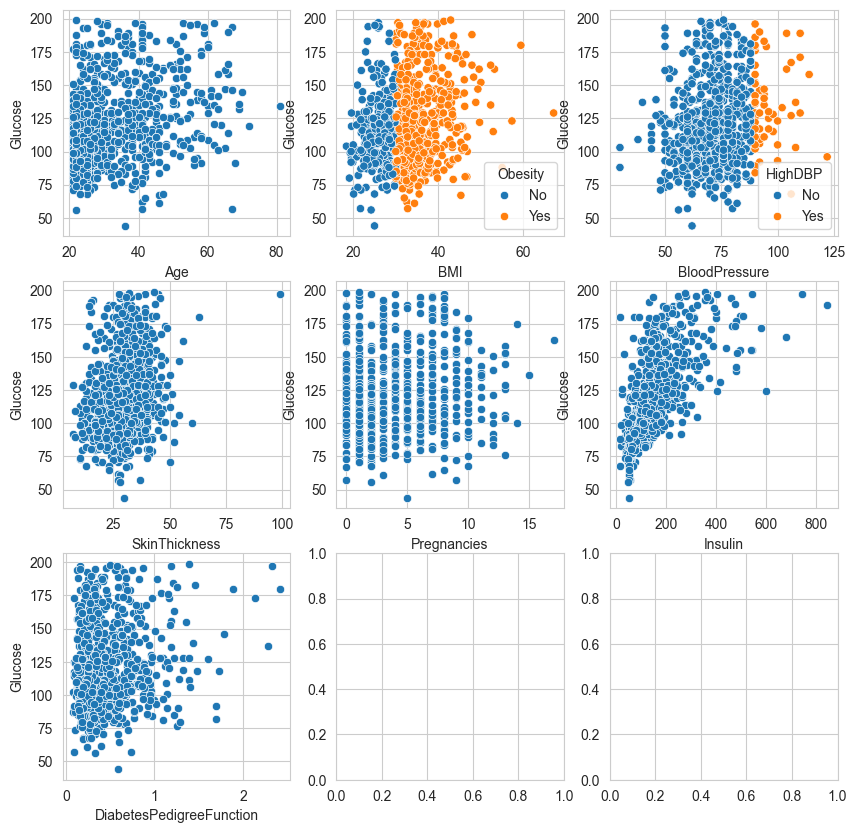

In [57]:
sns.set_style('whitegrid')

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

sns.scatterplot(x='Age', y='Glucose', data=df, ax=axs[0, 0])

sns.scatterplot(x='BMI', y='Glucose', data=df, hue='Obesity', ax=axs[0, 1])

sns.scatterplot(x='BloodPressure', y='Glucose', hue='HighDBP', data=df, ax=axs[0, 2])

sns.scatterplot(x='SkinThickness', y='Glucose', data=df, ax=axs[1, 0])

sns.scatterplot(x='Pregnancies', y='Glucose', data=df, ax=axs[1, 1])

sns.scatterplot(x='Insulin', y='Glucose', data=df, ax=axs[1, 2])

sns.scatterplot(x='DiabetesPedigreeFunction', y='Glucose', data=df, ax=axs[2, 0])

***There is a slightly positive correlation between Age, BMI, BloodPressure, SkinThickness, Insulin and Glucose***

# CREATING LOGISTIC REGRESSION MODEL FOR CLASSIFICATION

### Select features and target

In [58]:
X = df[['Age', 'Pregnancies', 'BMI',  'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction']]

y = df['Outcome']

###  Scaling numerical features with MinMaxScaler

In [59]:
mms = MinMaxScaler()

X_normalized = mms.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized, columns=['Age', 'Pregnancies', 'BMI',  'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction'])


### Spliting into training and test set

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size = 0.3)

### Class balancing of the target variable due existing of minority '1'  class, using oversampling with SMOTE algorithm in the train set

<Axes: xlabel='Outcome'>

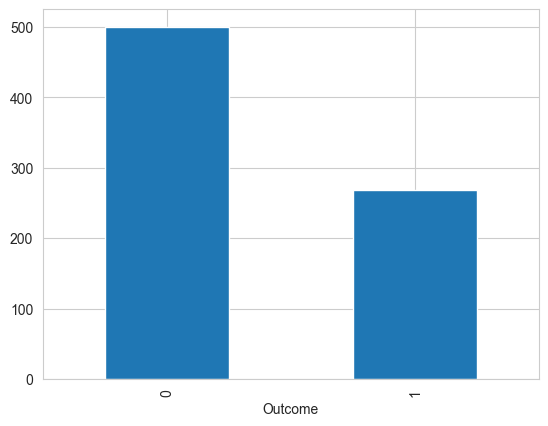

In [61]:
y.value_counts().plot(kind='bar')

In [62]:
counter = Counter(y_train)
print('Before', ':', counter)

sm = SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After', ':', counter)

Before : Counter({0: 354, 1: 183})
After : Counter({1: 354, 0: 354})


### Fitting and training the model

In [63]:
lr_model = LogisticRegression(max_iter=1000)

lr_model.fit(X_train_sm, y_train_sm)

LogisticRegression(max_iter=1000)

### Calculating accuracy and recall

In [64]:
y_pred = lr_model.predict(X_test)

print(f'Model Accuracy : {accuracy_score(y_pred, y_test)}')
print(f'Model Recall : {recall_score(y_pred, y_test)}')

Model Accuracy : 0.7748917748917749
Model Recall : 0.6666666666666666


In [66]:
lr_model.coef_

array([[ 1.21167532,  1.39892513,  2.66185509,  3.62775718, -0.77421193,
         1.03953252,  0.3936302 ,  1.7512496 ]])